In [117]:
import pandas as pd
import sqlite3
import contextlib 

sql_connect = sqlite3.connect('../database.sqlite')
cursor = sql_connect.cursor()

# SQL

Toon het aantal wedstrijden dat jouw team heeft gespeeld per seizoen.

In [118]:
matches_played = pd.read_sql("""SELECT season, COUNT(*) AS Manchester_United_Matches                                   
                                FROM Match
                                LEFT JOIN Team AS ht on ht.team_api_id = Match.home_team_api_id
                                LEFT JOIN Team AS at on at.team_api_id = Match.away_team_api_id 
                                WHERE ht.team_long_name == 'Manchester United' OR at.team_long_name == 'Manchester United'
                                GROUP BY season
                              ;""", sql_connect)
matches_played

,season,Manchester_United_Matches
0,2008/2009,38
1,2009/2010,38
2,2010/2011,38
3,2011/2012,38
4,2012/2013,38
5,2013/2014,38
6,2014/2015,38
7,2015/2016,38


Toon het aantal wedstrijden van jouw team in het kalenderjaar 2010 per seizoen.

In [119]:
matches_played_2010 = pd.read_sql("""SELECT season, COUNT(*) AS Manchester_United_Matches                              
                                FROM Match
                                LEFT JOIN Team AS ht on ht.team_api_id = Match.home_team_api_id
                                LEFT JOIN Team AS at on at.team_api_id = Match.away_team_api_id 
                                WHERE (ht.team_long_name == 'Manchester United' OR at.team_long_name == 'Manchester United')
                                        AND date LIKE '%2010%'
                                GROUP BY season
                              ;""", sql_connect)
matches_played_2010

,season,Manchester_United_Matches
0,2009/2010,18
1,2010/2011,18


Toon hoeveel punten ieder team in jouw competitie gehaald heeft per seizoen.

In [120]:
all_matches_df = pd.read_sql("""SELECT League.name AS league_name, 
                                        season, 
                                        ht.team_long_name AS  home_team,
                                        at.team_long_name AS away_team,
                                        home_team_goal, 
                                        away_team_goal                                        
                                FROM Match
                                JOIN Country on Country.id = Match.country_id
                                JOIN League on League.id = Match.league_id
                                LEFT JOIN Team AS ht on ht.team_api_id = Match.home_team_api_id
                                LEFT JOIN Team at on at.team_api_id = Match.away_team_api_id
                                WHERE league_name = "England Premier League"                           
                                ORDER by date;""", sql_connect)
all_matches_df

,league_name,season,home_team,away_team,home_team_goal,away_team_goal
0,England Premier League,2008/2009,Arsenal,West Bromwich Albion,1,0
1,England Premier League,2008/2009,Sunderland,Liverpool,0,1
2,England Premier League,2008/2009,West Ham United,Wigan Athletic,2,1
3,England Premier League,2008/2009,Everton,Blackburn Rovers,2,3
4,England Premier League,2008/2009,Middlesbrough,Tottenham Hotspur,2,1
...,...,...,...,...,...,...
3035,England Premier League,2015/2016,Stoke City,West Ham United,2,1
3036,England Premier League,2015/2016,Swansea City,Manchester City,1,1
3037,England Premier League,2015/2016,Watford,Sunderland,2,2
3038,England Premier League,2015/2016,West Bromwich Albion,Liverpool,1,1


In [144]:
def sql_decorator(func):
    def wrapper(*args, **kwargs):
        try:
            query = func(*args, **kwargs)
            result = pd.read_sql_query(query, sql_connect)
            return result
        except Exception as e:
            print("Error:", e)
    return wrapper

In [186]:
@sql_decorator
def win_loss_draw(league_id, season):
    result = f"""SELECT League.name AS league_name, 
                        season, 
                        ht.team_long_name AS home_team,
                        at.team_long_name AS away_team,
                        home_team_goal, 
                        away_team_goal,
                        CASE
                            WHEN home_team_goal > away_team_goal THEN 'Win'
                            WHEN home_team_goal < away_team_goal THEN 'Loss'
                            ELSE 'Draw'
                        END AS home_result,
                        CASE
                            WHEN home_team_goal < away_team_goal THEN 'Win'  
                            WHEN home_team_goal > away_team_goal THEN 'Loss'  
                            ELSE 'Draw' 
                        END AS away_result
                FROM Match
                JOIN Country ON Country.id = Match.country_id
                JOIN League ON League.id = Match.league_id
                LEFT JOIN Team AS ht ON ht.team_api_id = Match.home_team_api_id
                LEFT JOIN Team AS at ON at.team_api_id = Match.away_team_api_id
                WHERE league_id == {league_id}
                    AND season = '{season}'                     
                ORDER BY date;"""
    return result 

# Voorbeeldgebruik
win_loss_draw(1729, '2008/2009')

,league_name,season,home_team,away_team,home_team_goal,away_team_goal,home_result,away_result
0,England Premier League,2008/2009,Arsenal,West Bromwich Albion,1,0,Win,Loss
1,England Premier League,2008/2009,Sunderland,Liverpool,0,1,Loss,Win
2,England Premier League,2008/2009,West Ham United,Wigan Athletic,2,1,Win,Loss
3,England Premier League,2008/2009,Everton,Blackburn Rovers,2,3,Loss,Win
4,England Premier League,2008/2009,Middlesbrough,Tottenham Hotspur,2,1,Win,Loss
...,...,...,...,...,...,...,...,...
375,England Premier League,2008/2009,Manchester City,Bolton Wanderers,1,0,Win,Loss
376,England Premier League,2008/2009,Blackburn Rovers,West Bromwich Albion,0,0,Draw,Draw
377,England Premier League,2008/2009,Fulham,Everton,0,2,Loss,Win
378,England Premier League,2008/2009,Hull City,Manchester United,0,1,Loss,Win


In [196]:
@sql_decorator
def win_loss_draw(league_id, season):
    result = f"""SELECT League.name AS league_name, 
                        season, 
                        ht.team_long_name AS home_team,
                        at.team_long_name AS away_team,
                        home_team_goal, 
                        away_team_goal,
                        CASE
                            WHEN home_team_goal > away_team_goal THEN 3
                            WHEN home_team_goal < away_team_goal THEN 0
                            ELSE 1
                        END AS home_result,
                        CASE
                            WHEN home_team_goal < away_team_goal THEN 3 
                            WHEN home_team_goal > away_team_goal THEN 0  
                            ELSE 1 
                        END AS away_result
                FROM Match
                JOIN Country ON Country.id = Match.country_id
                JOIN League ON League.id = Match.league_id
                LEFT JOIN Team AS ht ON ht.team_api_id = Match.home_team_api_id
                LEFT JOIN Team AS at ON at.team_api_id = Match.away_team_api_id
                WHERE league_id == {league_id}
                    AND season = '{season}'                     
                ORDER BY date;"""
    return result 

# Voorbeeldgebruik
win_loss_draw(1729, '2008/2009')

,league_name,season,home_team,away_team,home_team_goal,away_team_goal,home_result,away_result
0,England Premier League,2008/2009,Arsenal,West Bromwich Albion,1,0,3,0
1,England Premier League,2008/2009,Sunderland,Liverpool,0,1,0,3
2,England Premier League,2008/2009,West Ham United,Wigan Athletic,2,1,3,0
3,England Premier League,2008/2009,Everton,Blackburn Rovers,2,3,0,3
4,England Premier League,2008/2009,Middlesbrough,Tottenham Hotspur,2,1,3,0
...,...,...,...,...,...,...,...,...
375,England Premier League,2008/2009,Manchester City,Bolton Wanderers,1,0,3,0
376,England Premier League,2008/2009,Blackburn Rovers,West Bromwich Albion,0,0,1,1
377,England Premier League,2008/2009,Fulham,Everton,0,2,0,3
378,England Premier League,2008/2009,Hull City,Manchester United,0,1,0,3


In [142]:
@sql_decorator
def select_query(league_id):
    result = f"""SELECT League.name AS league_name, 
                                        season, 
                                        ht.team_long_name AS  home_team,
                                        at.team_long_name AS away_team,
                                        home_team_goal, 
                                        away_team_goal                                        
                                FROM Match
                                JOIN Country on Country.id = Match.country_id
                                JOIN League on League.id = Match.league_id
                                LEFT JOIN Team AS ht on ht.team_api_id = Match.home_team_api_id
                                LEFT JOIN Team at on at.team_api_id = Match.away_team_api_id
                                WHERE league_id = {league_id}                          
                                ORDER by date"""
    return result 

select_query(1729)

,league_name,season,home_team,away_team,home_team_goal,away_team_goal
0,England Premier League,2008/2009,Arsenal,West Bromwich Albion,1,0
1,England Premier League,2008/2009,Sunderland,Liverpool,0,1
2,England Premier League,2008/2009,West Ham United,Wigan Athletic,2,1
3,England Premier League,2008/2009,Everton,Blackburn Rovers,2,3
4,England Premier League,2008/2009,Middlesbrough,Tottenham Hotspur,2,1
...,...,...,...,...,...,...
3035,England Premier League,2015/2016,Stoke City,West Ham United,2,1
3036,England Premier League,2015/2016,Swansea City,Manchester City,1,1
3037,England Premier League,2015/2016,Watford,Sunderland,2,2
3038,England Premier League,2015/2016,West Bromwich Albion,Liverpool,1,1


Toon op welke plaats jouw team daarmee is geëindigd in de ranglijst.

# Python

Maak een nieuw dataframe waarin het dataframe met onder andere het aantal punten per team wordt samengevoegd met het dataframe met daarin de teameigenschappen

In [202]:
attributes_df = pd.read_sql("""SELECT *
                                FROM Match
                                JOIN Country on Country.id = Match.country_id
                                JOIN League on League.id = Match.league_id
                                LEFT JOIN Team on Team.team_api_id = Match.home_team_api_id
                                LEFT JOIN Team_attributes ON (Team.team_fifa_api_id = Team_attributes.team_fifa_api_id)
                                    AND Team_attributes.date = Match.date                            
                                ORDER by Match.date;""", sql_connect)

attributes_df.head(2)

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,24559,24558,24558,2008/2009,1,2008-07-18 00:00:00,486263,10192,9931,1,...,NaN,None,None,NaN,None,NaN,None,NaN,None,None
1,24560,24558,24558,2008/2009,1,2008-07-19 00:00:00,486264,9930,10179,3,...,NaN,None,None,NaN,None,NaN,None,NaN,None,None


In [199]:
attributes_df = pd.read_sql("""SELECT League.name as league_name,
                                    season
                                                                           
                                FROM Match
                                JOIN Country on Country.id = Match.country_id
                                JOIN League on League.id = Match.league_id
                                LEFT JOIN Team on Team.team_api_id = Match.home_team_api_id
                                LEFT JOIN Team_attributes ON (Team.team_fifa_api_id = Team_attributes.team_fifa_api_id)
                                    AND Team_attributes.date = Match.date                            
                                ORDER by Match.date;""", sql_connect)

attributes_df.head()

,league_name,season
0,Switzerland Super League,2008/2009
1,Switzerland Super League,2008/2009
2,Switzerland Super League,2008/2009
3,Switzerland Super League,2008/2009
4,Switzerland Super League,2008/2009
...,...,...
25974,Switzerland Super League,2015/2016
25975,Switzerland Super League,2015/2016
25976,Switzerland Super League,2015/2016
25977,Switzerland Super League,2015/2016


In [167]:
# Dataframe uit sprint 2
team_points_df = pd.read_csv('team points.csv')
team_points_df

,Team,Win,Draw,Loss,Total Points
0,FC Barcelona,234.0,43.0,27.0,745.0
1,Real Madrid CF,228.0,36.0,40.0,720.0
2,Celtic,218.0,50.0,36.0,704.0
3,Juventus,189.0,66.0,46.0,633.0
4,Manchester United,192.0,57.0,55.0,633.0
...,...,...,...,...,...
291,Pescara,6.0,4.0,28.0,22.0
292,SpVgg Greuther Fürth,4.0,9.0,21.0,21.0
293,Córdoba CF,3.0,11.0,24.0,20.0
294,FC Dordrecht,4.0,8.0,22.0,20.0


In [187]:
team_points_attributes_df = attributes_df.merge(team_points_df, left_on='team_long_name', right_on='Team')
team_points_attributes_df

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass,Team,Win,Draw,Loss,Total Points
0,24559,24558,24558,2008/2009,1,2008-07-18 00:00:00,486263,10192,9931,1,...,NaN,None,NaN,None,None,BSC Young Boys,142.0,69.0,75.0,495.0
1,24671,24558,24558,2008/2009,3,2008-07-27 00:00:00,486275,10192,9824,0,...,NaN,None,NaN,None,None,BSC Young Boys,142.0,69.0,75.0,495.0
2,24717,24558,24558,2008/2009,5,2008-08-10 00:00:00,486289,10192,7955,2,...,NaN,None,NaN,None,None,BSC Young Boys,142.0,69.0,75.0,495.0
3,24727,24558,24558,2008/2009,7,2008-08-24 00:00:00,486299,10192,9930,3,...,NaN,None,NaN,None,None,BSC Young Boys,142.0,69.0,75.0,495.0
4,24731,24558,24558,2008/2009,8,2008-08-31 00:00:00,486303,10192,9956,1,...,NaN,None,NaN,None,None,BSC Young Boys,142.0,69.0,75.0,495.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25974,24391,21518,21518,2015/2016,29,2016-03-13 00:00:00,2030441,8306,8633,1,...,NaN,None,NaN,None,None,UD Las Palmas,12.0,8.0,18.0,44.0
25975,24422,21518,21518,2015/2016,31,2016-04-02 00:00:00,2030462,8306,10267,2,...,NaN,None,NaN,None,None,UD Las Palmas,12.0,8.0,18.0,44.0
25976,24443,21518,21518,2015/2016,33,2016-04-16 00:00:00,2030483,8306,9869,1,...,NaN,None,NaN,None,None,UD Las Palmas,12.0,8.0,18.0,44.0
25977,24464,21518,21518,2015/2016,35,2016-04-22 00:00:00,2030504,8306,8558,4,...,NaN,None,NaN,None,None,UD Las Palmas,12.0,8.0,18.0,44.0


Onderzoek in welke mate de teameigenschappen invloed hebben op het aantal punten. Maak hierbij gebruik van passende visualisaties.

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

In [73]:
def plot_decorator(func):
    """A decorator function which can be used to make sure all plots use colorblind-friendly colors and have a slighly darker background

    Parameters
    ----------
    func : function
        Input a function which creates a plot to alter the style
    """    
    def wrapper(*args, **kwargs):
        sns.set_theme(palette='colorblind', style='darkgrid')
        result = func(*args, **kwargs)
        plt.show()        
        return result
    return wrapper

@plot_decorator
def create_plot(df, x_axis, y_axis):
    """A function that creates a seaborn barchart to better visualize the data

    Parameters
    ----------
    df : DataFrame
        input a dataframe that contains a score column
    x_axis : str
        the column you want to be shown on the x-axis
    y_axis : str
        the column you want to be shown on the y-axis

    Returns
    -------
    catplot
        a plot is returned which shows a the teams sorted by the highest total points
    """    
    plot = sns.catplot(
        data=df,
        kind='bar',
        x=x_axis,
        y=y_axis,
        aspect=1.25
    )

    plt.title(f'Points scored per team in the {chosen_season} season in {chosen_country_name}.')
    return plot

NameError: name 'chosen_season' is not defined

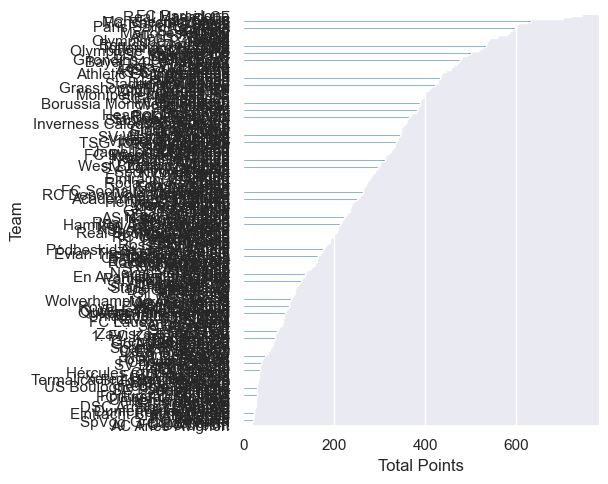

In [74]:
total_team_points_plot = create_plot(df=total_team_points,  
                          x_axis='Total Points', 
                          y_axis='Team')